In [22]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the dataset and copying
train_data = pd.read_csv('./train.csv').copy()
test_data = pd.read_csv('./test.csv').copy()

# Checking the dataset
train_data.head()
# Print the number of missing values in each column
train_data.isnull().sum()

# Made 

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

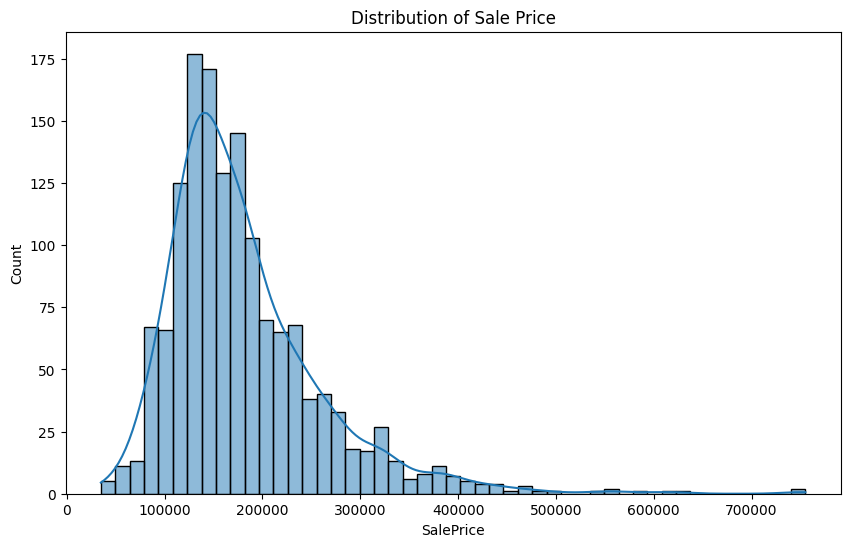

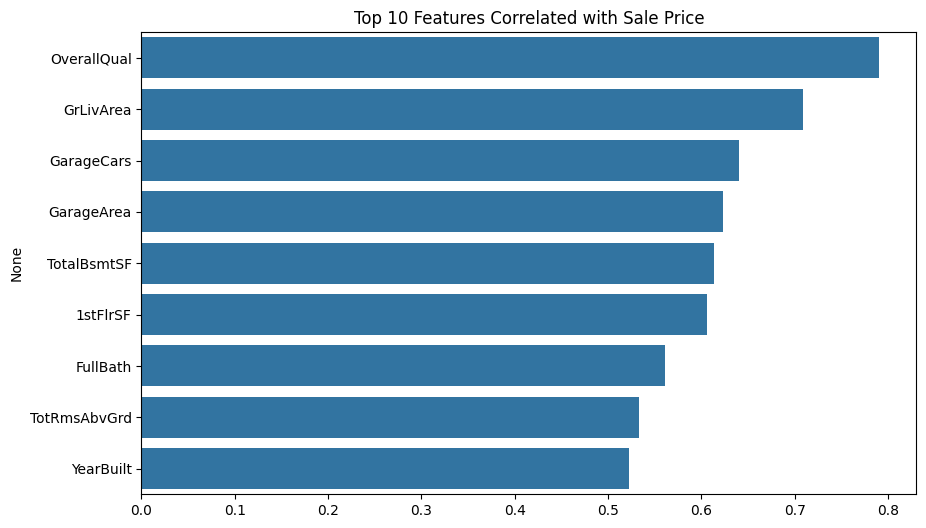

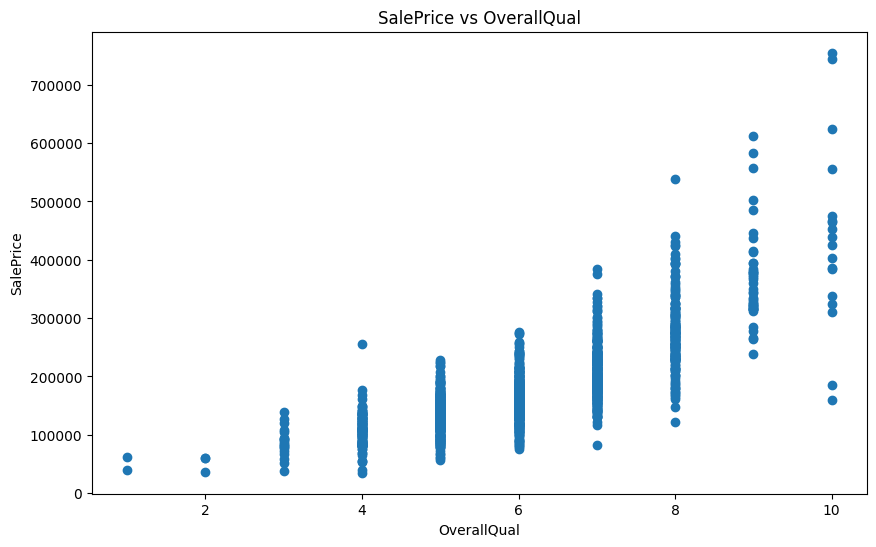

In [5]:
# Distribution of Sale Price
plt.figure(figsize=(10,6))
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('Distribution of Sale Price')
plt.show()

# Correlation between numerical features and SalePrice
numerical_features = train_data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = train_data[numerical_features].corr()

# Top 10 features correlated with SalePrice
top_corr = correlation_matrix['SalePrice'].sort_values(ascending=False)[:10]
# Exclude SalePrice from the plot
top_corr = top_corr.drop('SalePrice')
plt.figure(figsize=(10,6))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title('Top 10 Features Correlated with Sale Price')
plt.show()

# Relationship between the most correlated feature and SalePrice
top_feature = top_corr.index[0]  
plt.figure(figsize=(10,6))
plt.scatter(train_data[top_feature], train_data['SalePrice'])
plt.xlabel(top_feature)
plt.ylabel('SalePrice')
plt.title(f'SalePrice vs {top_feature}')
plt.show()

In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

def create_quality_features(df):
    """Create features related to quality scores"""
    qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0, 'None': 0}
    
    # Basic quality scores
    df['OverallGrade'] = df['OverallQual'] * df['OverallCond']
    df['ExterGrade'] = df['ExterQual'].map(qual_map) * df['ExterCond'].map(qual_map)
    df['KitchenScore'] = df['KitchenAbvGr'] * df['KitchenQual'].map(qual_map)
    df['FireplaceScore'] = df['Fireplaces'] * df['FireplaceQu'].map(qual_map)
    
    # Weighted quality score
    quality_weights = {
        'OverallQual': 0.4,
        'ExterQual': 0.1,
        'KitchenQual': 0.15,
        'BsmtQual': 0.15,
        'GarageQual': 0.1,
        'FireplaceQu': 0.1
    }
    
    for col in ['ExterQual', 'KitchenQual', 'BsmtQual', 'GarageQual', 'FireplaceQu']:
        df[f'{col}_num'] = df[col].map(qual_map)
    
    df['WeightedQual'] = sum(df[col if col == 'OverallQual' else f'{col}_num'] * weight 
                            for col, weight in quality_weights.items())
    
    return df

def create_area_features(df):
    """Create features related to various areas"""
    # Total areas
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = (df['FullBath'] + df['HalfBath'] * 0.5 + 
                           df['BsmtFullBath'] + df['BsmtHalfBath'] * 0.5)
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['EnclosedPorch'] + 
                         df['3SsnPorch'] + df['ScreenPorch'])
    df['TotalOutdoorSF'] = df['TotalPorchSF'] + df['WoodDeckSF']
    
    # Area ratios
    df['LivingAreaRatio'] = df['GrLivArea'] / df['LotArea']
    df['BasementRatio'] = df['TotalBsmtSF'] / df['1stFlrSF']
    df['LivingAreaPerRoom'] = df['GrLivArea'] / (df['TotRmsAbvGrd'] + 1)
    df['BuildingCoverage'] = df['1stFlrSF'] / df['LotArea']
    
    return df

def create_age_features(df):
    """Create features related to age and renovation"""
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['IsNewHouse'] = (df['YearBuilt'] == df['YrSold']).astype(int)
    df['YearsSinceRenovation'] = df['YrSold'] - df['YearRemodAdd']
    df['Never_Remodeled'] = (df['YearRemodAdd'] == df['YearBuilt']).astype(int)
    df['RecentRenovation'] = (df['YrSold'] - df['YearRemodAdd'] <= 2).astype(int)
    return df

def create_location_features(df, train_data):
    """Create features related to location and neighborhood"""
    # Price zones based on neighborhood
    neighborhood_prices = train_data.groupby('Neighborhood')['SalePrice'].median().to_dict()
    df['NeighborhoodPrice'] = df['Neighborhood'].map(neighborhood_prices)
    
    # Instead of categorical labels, use numerical bins
    df['PriceZone'] = pd.qcut(df['NeighborhoodPrice'].fillna(0), 
                             q=5, 
                             labels=False)  # Using numerical labels instead of strings
    
    # Neighbor conditions
    df['HasBadNeighbors'] = ((df['Condition1'].isin(['RRAn', 'RRNn'])) | 
                            (df['Condition2'].isin(['RRAn', 'RRNn']))).astype(int)
    df['HasGoodNeighbors'] = ((df['Condition1'].isin(['PosA', 'PosN'])) | 
                             (df['Condition2'].isin(['PosA', 'PosN']))).astype(int)
    return df

def create_polynomial_features(df):
    """Create polynomial features for important numerical variables"""
    important_nums = ['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'GarageArea', 'YearBuilt']
    poly = PolynomialFeatures(degree=2, include_bias=False)
    
    # Fit transform the data
    poly_features = poly.fit_transform(df[important_nums])
    
    # Get feature names for all features (including original and interaction terms)
    feature_names = poly.get_feature_names_out(important_nums)
    
    # Create dataframe with all polynomial features
    poly_df = pd.DataFrame(
        poly_features[:, len(important_nums):],  # Skip the original features
        columns=feature_names[len(important_nums):],  # Skip the original feature names
        index=df.index
    )
    
    return pd.concat([df, poly_df], axis=1)

def create_style_age_features(df):
    """Create style and age related features"""
    # Create age groups numerically instead of categories
    df['AgeGroup'] = pd.qcut(df['YearBuilt'], q=4, labels=False)
    
    # Create style-age interaction numerically
    df['StyleAge'] = df['AgeGroup'] * df['MSSubClass']
    
    return df

def preprocess_data(data, is_train=True, train_data=None):
    """
    Preprocess data with consistent transformations
    
    Parameters:
    -----------
    data : DataFrame
        The dataset to preprocess (either train or test)
    is_train : bool
        Whether this is the training dataset
    train_data : DataFrame
        The training dataset (needed for test preprocessing to ensure consistent transformations)
    """
    df = data.copy()
    
    # Handle missing values
    # For LotFrontage, use neighborhood medians from training data
    if is_train:
        neighborhood_medians = df.groupby('Neighborhood')['LotFrontage'].median()
    else:
        neighborhood_medians = train_data.groupby('Neighborhood')['LotFrontage'].median()
    
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(neighborhood_medians[x.name]))
    
    # Fill categorical NA's
    na_categorical = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                     'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
    for col in na_categorical:
        df[col].fillna('None', inplace=True)
    
    # Fill numerical NA's
    na_numeric = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
                 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
    for col in na_numeric:
        df[col].fillna(0, inplace=True)
    
    # Fill remaining NA's with mode from training data
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if is_train:
                fill_value = df[col].mode()[0]
            else:
                fill_value = train_data[col].mode()[0]
            df[col].fillna(fill_value, inplace=True)
    
    # Create features
    #df = create_quality_features(df)
    #df = create_area_features(df)
    #df = create_age_features(df)
    
    # Location features need training data for price zones
    if is_train:
        df = create_location_features(df, df)  # Use itself for training data
    else:
        df = create_location_features(df, train_data)
        
    #df = create_style_age_features(df)
    #df = create_polynomial_features(df)
    
    # Handle infinite values
    df = df.replace([np.inf, -np.inf], 0)
    
    # Convert categorical variables to dummy variables
    # Store or use training data columns to ensure consistent dummy variables
    if is_train:
        global categorical_columns
        categorical_columns = df.select_dtypes(include=['object']).columns
        df = pd.get_dummies(df, columns=categorical_columns)
        global dummy_columns
        dummy_columns = df.columns
    else:
        # Only create dummies for columns that existed in training data
        df = pd.get_dummies(df, columns=categorical_columns)
        # Add missing dummy columns from training data
        for col in dummy_columns:
            if col not in df.columns:
                df[col] = 0
        # Remove extra dummy columns that weren't in training data
        df = df[dummy_columns]
    
    return df

# Preprocess training data
X_train = preprocess_data(train_data, is_train=True)
y_train = np.log1p(train_data['SalePrice'])

# Preprocess test data using transformations learned from training data
X_test = preprocess_data(test_data, is_train=False, train_data=train_data)

# Print shapes to verify
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)

Training Features Shape: (1460, 307)
Testing Features Shape: (1459, 307)
Training Target Shape: (1460,)


/var/folders/m0/1t3tzh8133l9yzg22c9c3n6h0000gn/T/ipykernel_92687/2562451538.py:138: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('None', inplace=True)
/var/folders/m0/1t3tzh8133l9yzg22c9c3n6h0000gn/T/ipykernel_92687/2562451538.py:144: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [58]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import numpy as np

# 1. Ridge Regression with hyperparameter tuning
param_grid = {
    'alpha': [0.1, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

ridge = Ridge()
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Print results
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

# Get the best model
best_ridge = grid_search.best_estimator_

# Make predictions with the best model
ridge_pred = np.expm1(best_ridge.predict(X_test))

# Create submission file
submission = pd.DataFrame({
    'Id': test_data.Id,
    'SalePrice': ridge_pred
})
submission.to_csv('ridge_submission.csv', index=False)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameters: {'alpha': 5}
Best RMSE: 0.08366111866226666


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'colsample_bytree': np.float64(0.9013430550472151), 'learning_rate': np.float64(0.04586467812961639), 'max_depth': 5, 'min_child_samples': 21, 'min_split_gain': np.float64(0.03225507642386005), 'n_estimators': 1227, 'num_leaves': 20, 'reg_alpha': np.float64(0.13662133144202881), 'reg_lambda': np.float64(0.7089109969101186), 'subsample': np.float64(0.8658459930723723)}
Best RMSE: 0.045090864909915686


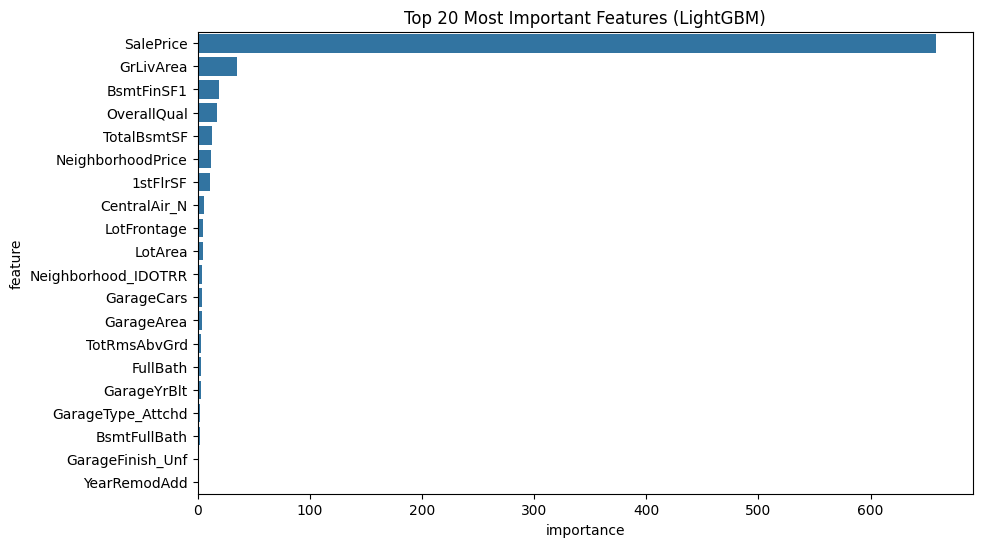

In [59]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# LightGBM with adjusted hyperparameter tuning
param_distributions = {
    'n_estimators': randint(100, 1500),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 8),
    'num_leaves': randint(20, 50),  # reduced from 100 to 50
    'min_child_samples': randint(20, 100),  # increased minimum
    'subsample': uniform(0.7, 0.3),  # adjusted range
    'colsample_bytree': uniform(0.7, 0.3),  # adjusted range
    'reg_alpha': uniform(0, 1),  # added L1 regularization
    'reg_lambda': uniform(0, 1),  # added L2 regularization
    'min_split_gain': uniform(0, 0.1)  # added minimum split gain
}

lgb = LGBMRegressor(
    random_state=42,
    n_jobs=-1,
    verbose=-1  # reduce verbosity
)

random_search = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_distributions,
    n_iter=50,  # reduced from 100 to 50
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Print results
print("Best parameters:", random_search.best_params_)
print("Best RMSE:", np.sqrt(-random_search.best_score_))

# Get the best model
best_lgb = random_search.best_estimator_

# Make predictions with the best model
lgb_pred = np.expm1(best_lgb.predict(X_test))

# Create submission file
submission = pd.DataFrame({
    'Id': test_data.Id,
    'SalePrice': lgb_pred
})
submission.to_csv('lgb_submission.csv', index=False)

# Plot feature importance
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_lgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_imp.head(20))
plt.title('Top 20 Most Important Features (LightGBM)')
plt.show()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


Best parameters: {'colsample_bytree': np.float64(0.8834959481464842), 'gamma': np.float64(0.003533152609858703), 'learning_rate': np.float64(0.012306242504141576), 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 610, 'reg_alpha': np.float64(0.13949386065204183), 'reg_lambda': np.float64(0.29214464853521815), 'subsample': np.float64(0.8099085529881075)}
Best RMSE: 0.023906392686566188


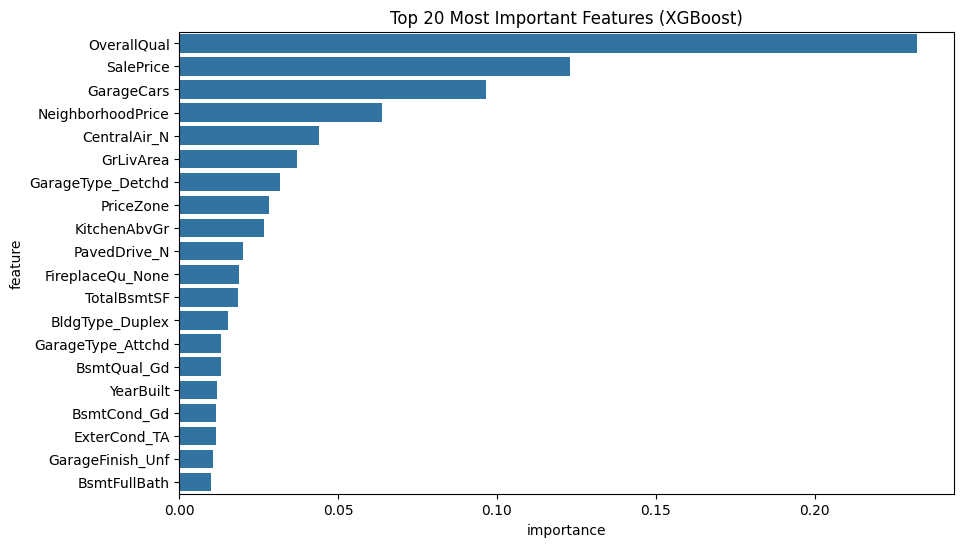

In [60]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# XGBoost with hyperparameter tuning
param_distributions = {
    'n_estimators': randint(100, 1500),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.1),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'min_child_weight': randint(1, 7),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

xgb = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    verbosity=0  # reduce verbosity
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Print results
print("Best parameters:", random_search.best_params_)
print("Best RMSE:", np.sqrt(-random_search.best_score_))

# Get the best model
best_xgb = random_search.best_estimator_

# Make predictions with the best model
xgb_pred = np.expm1(best_xgb.predict(X_test))

# Create submission file
submission = pd.DataFrame({
    'Id': test_data.Id,
    'SalePrice': xgb_pred
})
submission.to_csv('xgb_submission.csv', index=False)

# Plot feature importance
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_imp.head(20))
plt.title('Top 20 Most Important Features (XGBoost)')
plt.show()

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5

Optimal weights:
Ridge: 0.0548
LightGBM: 0.0582
XGBoost: 0.8870
Best CV RMSE: 0.025734


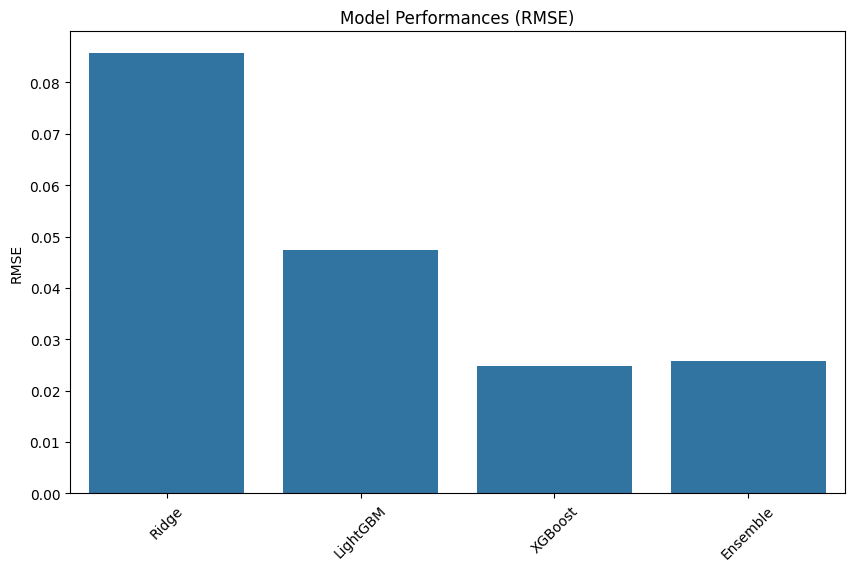

In [61]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

def find_optimal_weights(predictions, y, n_trials=1000):
    """Find optimal weights using random search"""
    best_score = float('inf')
    best_weights = None
    
    for _ in range(n_trials):
        # Generate random weights and normalize them
        weights = np.random.uniform(0, 1, size=len(predictions))
        weights = weights / np.sum(weights)
        
        # Calculate weighted average
        weighted_pred = np.zeros_like(predictions[0])
        for weight, pred in zip(weights, predictions):
            weighted_pred += weight * pred
            
        # Calculate RMSE
        score = np.sqrt(mean_squared_error(y, weighted_pred))
        
        if score < best_score:
            best_score = score
            best_weights = weights
    
    return best_weights, best_score

# Perform k-fold cross validation to get out-of-fold predictions
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize arrays to store predictions
oof_ridge = np.zeros(len(X_train))
oof_lgb = np.zeros(len(X_train))
oof_xgb = np.zeros(len(X_train))

# Initialize arrays to store test predictions
test_ridge = np.zeros(len(X_test))
test_lgb = np.zeros(len(X_test))
test_xgb = np.zeros(len(X_test))

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train models
    best_ridge.fit(X_tr, y_tr)
    best_lgb.fit(X_tr, y_tr)
    best_xgb.fit(X_tr, y_tr)
    
    # Make predictions on validation set
    oof_ridge[val_idx] = best_ridge.predict(X_val)
    oof_lgb[val_idx] = best_lgb.predict(X_val)
    oof_xgb[val_idx] = best_xgb.predict(X_val)
    
    # Make predictions on test set
    test_ridge += best_ridge.predict(X_test) / n_folds
    test_lgb += best_lgb.predict(X_test) / n_folds
    test_xgb += best_xgb.predict(X_test) / n_folds

# Find optimal weights using out-of-fold predictions
predictions = [oof_ridge, oof_lgb, oof_xgb]
optimal_weights, best_score = find_optimal_weights(predictions, y_train)

print("\nOptimal weights:")
print(f"Ridge: {optimal_weights[0]:.4f}")
print(f"LightGBM: {optimal_weights[1]:.4f}")
print(f"XGBoost: {optimal_weights[2]:.4f}")
print(f"Best CV RMSE: {best_score:.6f}")

# Make final predictions using optimal weights
final_pred = np.zeros(len(X_test))
for weight, pred in zip(optimal_weights, [test_ridge, test_lgb, test_xgb]):
    final_pred += weight * pred

# Transform predictions back to original scale
final_pred = np.expm1(final_pred)

# Create submission file
submission = pd.DataFrame({
    'Id': test_data.Id,
    'SalePrice': final_pred
})
submission.to_csv('ensemble_submission.csv', index=False)

# Plot individual model performances and ensemble performance
model_names = ['Ridge', 'LightGBM', 'XGBoost', 'Ensemble']
cv_scores = [
    np.sqrt(mean_squared_error(y_train, oof_ridge)),
    np.sqrt(mean_squared_error(y_train, oof_lgb)),
    np.sqrt(mean_squared_error(y_train, oof_xgb)),
    best_score
]

plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=cv_scores)
plt.title('Model Performances (RMSE)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# import original test data
test_data = pd.read_csv('./test.csv')

# use the ensemble model to predict the test data
test_pred = np.expm1(best_ensemble.predict(X_test))

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Random Forest with extensive parameter tuning
rf_params = {
    'n_estimators': randint(100, 2000),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 15),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'max_samples': uniform(0.5, 0.5),  # for bootstrap
    'criterion': ['squared_error', 'absolute_error', 'poisson']
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=100,  # increased number of iterations
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit and evaluate
rf_random.fit(X_train, y_train)
print("Best Random Forest parameters:", rf_random.best_params_)
print("Best RMSE:", np.sqrt(-rf_random.best_score_))

# Make predictions
rf_pred = np.expm1(rf_random.predict(X_test))
rf_submission = pd.DataFrame({
    'Id': test_data.Id,
    'SalePrice': rf_pred
})
rf_submission.to_csv('rf_submission.csv', index=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, criterion=squared_error, max_depth=17, max_features=None, max_samples=0.8898455001363846, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   6.3s
[CV] END bootstrap=True, criterion=squared_error, max_depth=17, max_features=None, max_samples=0.8898455001363846, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   6.6s
[CV] END bootstrap=True, criterion=squared_error, max_depth=17, max_features=None, max_samples=0.8898455001363846, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   6.6s
[CV] END bootstrap=True, criterion=squared_error, max_depth=17, max_features=None, max_samples=0.8898455001363846, min_samples_leaf=5, min_samples_split=8, n_estimators=221; total time=   6.6s
[CV] END bootstrap=True, criterion=squared_error, max_depth=17, max_features=None, max_samples=0.8898455001363846, min_samples_leaf=5, min_samples_split=8, n_estimat

/Users/MainUser/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
255 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
255 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/MainUser/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/MainUser/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/MainUser/.pyenv/versions/3

Best Random Forest parameters: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 18, 'max_features': None, 'max_samples': np.float64(0.9323611881275267), 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 1986}
Best RMSE: 0.1333618118798568


In [36]:
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting with extensive parameter tuning
gb_params = {
    'n_estimators': randint(100, 2000),
    'learning_rate': uniform(0.01, 0.19),
    'max_depth': randint(3, 12),
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 15),
    'subsample': uniform(0.5, 0.5),
    'max_features': uniform(0.5, 0.5),
    'alpha': uniform(0.1, 0.9),  # for quantile loss
    'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'criterion': ['friedman_mse', 'squared_error']
}

gb = GradientBoostingRegressor(random_state=42)
gb_random = RandomizedSearchCV(
    estimator=gb,
    param_distributions=gb_params,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit and evaluate
gb_random.fit(X_train, y_train)
print("Best Gradient Boosting parameters:", gb_random.best_params_)
print("Best RMSE:", np.sqrt(-gb_random.best_score_))

# Make predictions
gb_pred = np.expm1(gb_random.predict(X_test))
gb_submission = pd.DataFrame({
    'Id': test_data.Id,
    'SalePrice': gb_pred
})
gb_submission.to_csv('gb_submission.csv', index=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END alpha=0.4370861069626263, criterion=friedman_mse, learning_rate=0.04485261007457112, loss=quantile, max_depth=7, max_features=0.5780093202212182, min_samples_leaf=3, min_samples_split=24, n_estimators=430, subsample=0.7296244459829335; total time=   9.4s
[CV] END alpha=0.4370861069626263, criterion=friedman_mse, learning_rate=0.04485261007457112, loss=quantile, max_depth=7, max_features=0.5780093202212182, min_samples_leaf=3, min_samples_split=24, n_estimators=430, subsample=0.7296244459829335; total time=   9.4s
[CV] END alpha=0.4370861069626263, criterion=friedman_mse, learning_rate=0.04485261007457112, loss=quantile, max_depth=7, max_features=0.5780093202212182, min_samples_leaf=3, min_samples_split=24, n_estimators=430, subsample=0.7296244459829335; total time=   9.5s
[CV] END alpha=0.4370861069626263, criterion=friedman_mse, learning_rate=0.04485261007457112, loss=quantile, max_depth=7, max_features=0.57800932

In [40]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

# Scale the features for Elastic Net
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Elastic Net with extensive parameter tuning
elastic_params = {
    'alpha': uniform(0.0001, 1),
    'l1_ratio': uniform(0, 1),
    'max_iter': [5000],
    'tol': uniform(1e-5, 1e-4),
    'selection': ['cyclic', 'random']
}

elastic = ElasticNet(random_state=42)
elastic_random = RandomizedSearchCV(
    estimator=elastic,
    param_distributions=elastic_params,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit and evaluate
elastic_random.fit(X_train_scaled, y_train)
print("Best Elastic Net parameters:", elastic_random.best_params_)
print("Best RMSE:", np.sqrt(-elastic_random.best_score_))

# Make predictions
elastic_pred = np.expm1(elastic_random.predict(X_test_scaled))
elastic_submission = pd.DataFrame({
    'Id': test_data.Id,
    'SalePrice': elastic_pred
})
elastic_submission.to_csv('elastic_submission.csv', index=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END alpha=0.3746401188473625, l1_ratio=0.9507143064099162, max_iter=5000, selection=cyclic, tol=8.796910002727693e-05; total time=   0.0s
[CV] END alpha=0.3746401188473625, l1_ratio=0.9507143064099162, max_iter=5000, selection=cyclic, tol=8.796910002727693e-05; total time=   0.0s
[CV] END alpha=0.3746401188473625, l1_ratio=0.9507143064099162, max_iter=5000, selection=cyclic, tol=8.796910002727693e-05; total time=   0.0s
[CV] END alpha=0.3746401188473625, l1_ratio=0.9507143064099162, max_iter=5000, selection=cyclic, tol=8.796910002727693e-05; total time=   0.0s
[CV] END alpha=0.596950157946487, l1_ratio=0.44583275285359114, max_iter=5000, selection=cyclic, tol=1.5808361216819946e-05; total time=   0.0s
[CV] END alpha=0.596950157946487, l1_ratio=0.44583275285359114, max_iter=5000, selection=cyclic, tol=1.5808361216819946e-05; total time=   0.0s
[CV] END alpha=0.596950157946487, l1_ratio=0.44583275285359114, max_iter=5000

In [38]:
from sklearn.kernel_ridge import KernelRidge

# Kernel Ridge with extensive parameter tuning
kr_params = {
    'alpha': uniform(0.0001, 1),
    'kernel': ['rbf', 'polynomial', 'laplacian', 'linear'],
    'degree': randint(2, 5),
    'coef0': uniform(0, 1),
    'gamma': uniform(0.0001, 0.1)
}

kr = KernelRidge()
kr_random = RandomizedSearchCV(
    estimator=kr,
    param_distributions=kr_params,
    n_iter=100,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit and evaluate
kr_random.fit(X_train_scaled, y_train)  # Using scaled data
print("Best Kernel Ridge parameters:", kr_random.best_params_)
print("Best RMSE:", np.sqrt(-kr_random.best_score_))

# Make predictions
kr_pred = np.expm1(kr_random.predict(X_test_scaled))
kr_submission = pd.DataFrame({
    'Id': test_data.Id,
    'SalePrice': kr_pred
})
kr_submission.to_csv('kr_submission.csv', index=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END alpha=0.3746401188473625, coef0=0.9507143064099162, degree=4, gamma=0.07806910002727693, kernel=rbf; total time=   0.2s
[CV] END alpha=0.1561186404424365, coef0=0.15599452033620265, degree=4, gamma=0.04602488919658672, kernel=rbf; total time=   0.2s
[CV] END alpha=0.3746401188473625, coef0=0.9507143064099162, degree=4, gamma=0.07806910002727693, kernel=rbf; total time=   0.2s
[CV] END alpha=0.3746401188473625, coef0=0.9507143064099162, degree=4, gamma=0.07806910002727693, kernel=rbf; total time=   0.2s
[CV] END alpha=0.3746401188473625, coef0=0.9507143064099162, degree=4, gamma=0.07806910002727693, kernel=rbf; total time=   0.2s
[CV] END alpha=0.3746401188473625, coef0=0.9507143064099162, degree=4, gamma=0.07806910002727693, kernel=rbf; total time=   0.2s
[CV] END alpha=0.1561186404424365, coef0=0.15599452033620265, degree=4, gamma=0.04602488919658672, kernel=rbf; total time=   0.1s
[CV] END alpha=0.156118640442436

In [41]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Create base models using best parameters found
best_rf = RandomForestRegressor(**rf_random.best_params_, random_state=42)
best_gb = GradientBoostingRegressor(**gb_random.best_params_, random_state=42)
best_elastic = ElasticNet(**elastic_random.best_params_, random_state=42)
best_kr = KernelRidge(**kr_random.best_params_)

# Create the stacking model
estimators = [
    ('rf', best_rf),
    ('gb', best_gb),
    ('elastic', best_elastic),
    ('kr', best_kr)
]

stacking = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)

# Fit stacking model
stacking.fit(X_train_scaled, y_train)

# Make predictions
stacking_pred = np.expm1(stacking.predict(X_test_scaled))
stacking_submission = pd.DataFrame({
    'Id': test_data.Id,
    'SalePrice': stacking_pred
})
stacking_submission.to_csv('stacking_submission.csv', index=False)